In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox, Toplevel
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.cluster import KMeans
from scipy.spatial import distance
from tqdm import tqdm
import random
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

sns.set_style('whitegrid')

# Wszystkie potrzebne funkcje (wersja S)

In [88]:
def closest_pair_distance(points):
    """
    Calculate the smallest Euclidean distance between any two points in a list.

    This function iterates through each pair of points in the provided list, calculating
    the Euclidean distance between them to find and return the minimum distance found.

    Parameters:
    points (list of tuples/lists): A list where each element is a point in n-dimensional space
    represented as a tuple or list of coordinates.

    Returns:
    float: The smallest Euclidean distance between any two points in the provided list.
    """
    min_distance = float('inf')
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            dist = distance.euclidean(points[i], points[j])
            if dist < min_distance:
                min_distance = dist
    return min_distance

def check_irrigation(data, clusters_centers, r: list):
    """
    Evaluate the irrigation status of points in a dataset based on their proximity to specified cluster centers.

    This function assesses each point in the `data` list to determine its irrigation status relative to 
    cluster centers. A point is considered irrigated if it lies within the radius of exactly one cluster center,
    non-irrigated if it does not lie within the radius of any cluster center, and multiply irrigated if it lies 
    within the radii of multiple cluster centers. The function returns the proportion of points in each category.

    Parameters:
    data (list of tuples/lists): List of points, where each point is represented as a tuple or list of coordinates (x, y).
    clusters_centers (list of tuples/lists): List of cluster centers, where each center is represented as a tuple or list of coordinates (x, y).
    r (list of floats): List of radii corresponding to each cluster center.

    Returns:
    tuple of floats: A tuple containing three proportions (as floats) of the dataset:
                     1. Proportion of irrigated points.
                     2. Proportion of non-irrigated points.
                     3. Proportion of multiply irrigated points.
    """
    
    irrigated = 0
    non_irrigated = 0
    multiple_irrigated = 0
    for xy in data:
        counter = 0
        idx = -1
        for c in clusters_centers:
            idx += 1
            if ((xy[0] - c[0])**2 + (xy[1] - c[1])**2 <= r[idx]**2):
                counter += 1
        if counter == 1:
            irrigated += 1
        elif counter == 0:
            non_irrigated += 1
        else:
            multiple_irrigated += 1
    return irrigated/len(data), non_irrigated/len(data), multiple_irrigated/len(data)

def closest_pair(points, index_of_center):
    """
    Find the index of the closest point to a specified center point within a list of points, excluding the center itself.

    This function calculates the Euclidean distance from the specified center point to each other point in the list.
    It returns the index of the point that is closest to the center but not closer than a certain threshold distance,
    thereby excluding the center point itself from consideration.

    Parameters:
    points (list of tuples/lists): A list where each element is a point in n-dimensional space represented as a tuple or list of coordinates.
    index_of_center (int): The index of the center point in the `points` list.

    Returns:
    float: The index of the point closest to the center point, excluding the center itself if it's the closest.
           Returns float('inf') if no suitable point is found.

    Note:
    A minimum distance threshold of 0.1 is used to exclude the center itself or points too close to it from being considered as the closest point.
    """

    current_cluster = points[index_of_center]
    
    min_distance = float('inf')
    index = float('inf')
    for i in range(len(points)):
        dist = distance.euclidean(current_cluster, points[i])
        if dist < min_distance:
            if dist > 0.1: # odrzucenie przypadku trafienia na ten sam środek zraszacza
                min_distance = dist
                index = i
        
    return index


def radius_expander(center, center_radius, closest_center, closest_center_radius, circuit):
    increment = 0.5
    t = True
    while t:
        if distance.euclidean(center, closest_center) <= center_radius + closest_center_radius:
            t = False
            break
        for xy in circuit:
            if distance.euclidean(center, xy) <= center_radius:
                t = False
                break
        center_radius += increment
    center_radius -= increment
    return center_radius
    
def closest_pair_modified(points, current_cluster):
    """ Algorytm zwracający indeks punktu najmniej odległego od zadanego punktu"""

    min_distance = float('inf')
    index = float('inf')
    for i in range(len(points)):
        dist = distance.euclidean(current_cluster, points[i])
        if dist < min_distance:
            if dist > 0.1: # odrzucenie przypadku trafienia na ten sam środek zraszacza
                min_distance = dist
                index = i
        
    return index

# wcześniejsza wersja, aktualnie nieużywana
from copy import deepcopy, copy
def circle_shift(input_centers, input_radiuses, circuit):
    cl_centers = copy(input_centers)
    cl_radiuses = copy(input_radiuses)
    idxs = np.argmin(cl_radiuses)
    smallest_center = cl_centers[idxs]
    smallest_radius =cl_radiuses[idxs]
    rest_of_centers = np.delete(cl_centers, idxs, axis=0)
    rest_of_radiuses = np.delete(cl_radiuses, idxs)
    idx_del = -1
    for cs, rs in zip(rest_of_centers, rest_of_radiuses):
        idx_del += 1
        if distance.euclidean(cs, smallest_center) <= smallest_radius + rs + 1:
            # crucial_point = smallest_center + (cs - smallest_center) * smallest_radius/(smallest_radius + rs)
            vector = -(cs - smallest_center)
            norm = np.linalg.norm(vector)
            normalised_vect = vector / norm
            proportion = 0.5
            rest_of_radiuses = np.delete(rest_of_radiuses, idx_del, axis=0)
            rest_of_centers = np.delete(rest_of_centers, idx_del, axis=0)
            idx_closest = closest_pair_modified(rest_of_centers, smallest_center)
            closest_center = rest_of_centers[idx_closest]
            closest_radius = rest_of_radiuses[idx_closest]
            t = True
            while t: # dopóki nie jest styczny z resztą!
                smallest_center += proportion * normalised_vect
                smallest_radius += proportion
                if distance.euclidean(closest_center, smallest_center) <= smallest_radius + closest_radius:
                    t = False
                    break
                for xy in circuit:
                    if distance.euclidean(smallest_center, xy) <= smallest_radius:
                        t = False
                        break
            smallest_center -= proportion * normalised_vect
            smallest_radius -= proportion
            cl_centers[idxs] = smallest_center
            cl_radiuses[idxs] = smallest_radius
            return cl_centers, cl_radiuses
    # dodać przypadek w którym jest styczne do obwodu!!!!    

def circle_shift_all(input_centers, input_radiuses, circuit):
    cl_centers = copy(input_centers)   # czy posortowanie cos zmieni?
    cl_radiuses = copy(input_radiuses)   # kopiowanie, aby nie zmieniały się tablice dostarczone jako argumenty
    for idxs in range(len(cl_centers)):     # iteracja po wszystkich centrach
        current_center = cl_centers[idxs]
        current_radius =cl_radiuses[idxs]
        rest_of_centers = np.delete(cl_centers, idxs, axis=0)
        rest_of_radiuses = np.delete(cl_radiuses, idxs)
        idx_del = -1
        for cs, rs in zip(rest_of_centers, rest_of_radiuses):
            idx_del += 1
            if distance.euclidean(cs, current_center) <= current_radius + rs + 1 :  # +1 dla pewności styczności (niedokładność, która wynika z wcześniejszych błędów numerycznych)
                vector = -(cs - current_center)
                norm = np.linalg.norm(vector)
                normalised_vect = vector / norm
                proportion = 0.5
                rest_of_radiuses = np.delete(rest_of_radiuses, idx_del, axis=0)
                rest_of_centers = np.delete(rest_of_centers, idx_del, axis=0)
                # idx_closest = closest_pair_modified(rest_of_centers, current_center)
                # closest_center = rest_of_centers[idx_closest]
                # closest_radius = rest_of_radiuses[idx_closest]
                t = True
                while t: # dopóki nie jest styczny z resztą!
                    current_center += proportion * normalised_vect
                    current_radius += proportion
                    for cents, rads in zip(rest_of_centers, rest_of_radiuses):
                        if distance.euclidean(cents, current_center) <= current_radius + rads:
                            t = False
                            break
                    # if distance.euclidean(closest_center, current_center) <= current_radius + closest_radius:
                    #     t = False
                    #     break
                    for xy in circuit:
                        if distance.euclidean(current_center, xy) <= current_radius:
                            t = False
                            break
                current_center -= proportion * normalised_vect
                current_radius -= proportion
                cl_centers[idxs] = current_center
                cl_radiuses[idxs] = current_radius
                break  # tutaj break pomógł!
    return cl_centers, cl_radiuses
    # dodać przypadek w którym jest styczne do obwodu!!!!    

def min_spanning_tree(points):
    # Obliczanie macierzy odległości
    dist_matrix = squareform(pdist(points))
    # Tworzenie macierzy rzadkiej z macierzy odległości
    graph = csr_matrix(dist_matrix)
    # Wyznaczanie MST
    mst = minimum_spanning_tree(graph)
    # Konwertowanie wyniku do macierzy pełnej
    mst_full = mst.toarray()
    # suma odległości
    mst_weight_sum = mst_full.sum()
    return mst_weight_sum, mst_full   

def clustering_with_graph(n_clusters, dane_do_klastrowania, dane_pełne, obwód, plot=True, graph_plot=True):
    k_means = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(dane_do_klastrowania)   # klastrowanie
    centers_local = k_means.cluster_centers_
    
    min_dst = closest_pair_distance(centers_local)
    r_start = min_dst/8         # zmniejszony 8 zamiast 2 razy, żeby było miejsce na powiększanie (przy 2 styczność)
    min_rs = r_start * np.ones(len(centers_local)) 
    for i in range(len(centers_local)):
            closest_cluster_idx = closest_pair(centers_local, i)
    
            min_rs[i] = radius_expander(centers_local[i], min_rs[i], centers_local[closest_cluster_idx], min_rs[closest_cluster_idx], obwód)
    final_centers, final_radiuses = circle_shift_all(centers_local, min_rs, obwód)
    
    irr = check_irrigation(dane_pełne, final_centers, final_radiuses)
    
    if plot:
        figure, axes = plt.subplots()
        plt.scatter(dane_pełne[:, 0], dane_pełne[:, 1], alpha=0.4, s=3, c='g')
        for xy, r in zip(final_centers, final_radiuses):
            circle = plt.Circle(xy, r, facecolor='dodgerblue', edgecolor='navy', linewidth=0.5, alpha=0.9)
            # circle = plt.Circle(xy, r, color='dodgerblue', alpha=0.9)
            axes.add_artist(circle)
    
    garden_hose_length, mst_full_arr = min_spanning_tree(final_centers)
    
    if graph_plot:
        # Rysowanie punktów
        plt.scatter(final_centers[:, 0], final_centers[:, 1], color='red', s=10)

        # Rysowanie krawędzi MST
        for i in range(len(final_centers)):
            for j in range(len(final_centers)):
                if mst_full_arr[i, j] > 0:
                    plt.plot([final_centers[i, 0], final_centers[j, 0]], [final_centers[i, 1], final_centers[j, 1]], 'b-', alpha=0.3)
    figure.patch.set_alpha(0.0)
    # plt.savefig(f"Graph_alf2{n_clusters}")
    # plt.show()
    return final_radiuses, final_centers, garden_hose_length, irr, figure


# funkcje do zbierania danych oraz liczenia obwodu
def extract_data(img, new_width, new_height):
    
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)
    numpydata = np.asarray(resized_img)
    
    x_in = np.array([])
    y_in = np.array([])
    
    if len(numpydata.shape) == 3: # obraz w kolorze, 3D
        height, width, rgb = numpydata.shape
        black_rgb = np.array([0, 0, 0])
        
        for h in tqdm(range(height)):
            for w in range(width):
                if np.array_equal(numpydata[h, w], black_rgb):
                    x_in = np.append(x_in, w)
                    y_in = np.append(y_in, h)
    elif len(numpydata.shape) == 2: # obraz w skali szarości, 2D
        height, width = numpydata.shape
        black_rgb = 0

        for h in tqdm(range(height)):
            for w in range(width):
                if numpydata[h, w] == black_rgb:
                    x_in = np.append(x_in, w)
                    y_in = np.append(y_in, h)
    else:
        return ValueError("Something's wrong with input picture")
    
    # ważny kod do tego, aby przetworzony obraz nie był obracany!
    y_in = new_height - y_in
    
    # dane do plotowania plus obwodu
    data_dense = np.column_stack((x_in, y_in))
    np.save("Punkty", data_dense)

    # dane do klastrowania
    data = np.load("Punkty.npy", allow_pickle=True)

    
    # obwód!
    matrix = np.zeros((width, height))
    for xy in data_dense:
        matrix[int(xy[0]), int(xy[1])] = 1
    
    indices_of_neighbours = np.array([[-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1], [1, 0], [1, 1], [0, 1]], dtype=int)
    # obwod_dane = np.array([])
    x_in = np.array([])
    y_in = np.array([])
    
    amount_of_neighbours = 2
    
    for i in tqdm(range(width)):
        for k in range(height):
            if matrix[i, k]:    # jeśli mamy w danej komórce punkt
                counter = 0
                for idx in indices_of_neighbours:
                    if matrix[i + idx[0], k + idx[1]]:
                        counter += 1
                if counter <= amount_of_neighbours:
                    x_in = np.append(x_in, i)
                    y_in = np.append(y_in, k)
                    # obwod_dane = np.append(obwod_dane, np.array([i, k]))
    
    obwod_dane_dense = np.column_stack((x_in, y_in))
    
    return data, data_dense, obwod_dane_dense

# Wszystkie potrzebne funkcje (wersja A)

In [89]:
class Circle:
    """A little class representing an SVG circle."""

    def __init__(self, cx, cy, r, icolour=None):
        """Initialize the circle with its centre, (cx,cy) and radius, r.

        icolour is the index of the circle's colour.

        """
        self.cx, self.cy, self.r = cx, cy, r
        self.icolour = icolour

    def overlap_with(self, cx, cy, r):
        """Does the circle overlap with another of radius r at (cx, cy)?"""

        d = np.hypot(cx-self.cx, cy-self.cy)
        return d < r + self.r

    def draw_circle(self, fo):
        """Write the circle's SVG to the output stream, fo."""

        print('<circle cx="{}" cy="{}" r="{}" class="c{}"/>'
            .format(self.cx, self.cy, self.r, self.icolour), file=fo)

class Circles:
    """A class for drawing circles-inside-a-circle."""
    
    def __init__(self, width=600, height=600, R=250, n=800, rho_min=0.005,
                 rho_max=0.05, r_list = [1, 2, 3], colours=None):
        """Initialize the Circles object.

        width, height are the SVG canvas dimensions
        R is the radius of the large circle within which the small circles are
        to fit.
        n is the maximum number of circles to pack inside the large circle.
        rho_min is rmin/R, giving the minimum packing circle radius.
        rho_max is rmax/R, giving the maximum packing circle radius.
        colours is a list of SVG fill colour specifiers to be referenced by
            the class identifiers c<i>. If None, a default palette is set.

        """

        self.width, self.height = width, height
        self.R, self.n = R, n
        # The centre of the canvas
        self.CX, self.CY = self.width // 2, self.height // 2
        self.rmin, self.rmax = R * rho_min, R * rho_max
        self.colours = colours or ['#993300', '#a5c916', '#00AA66', '#FF9900']
        self.circles = []
        self.r_list = r_list
        # The "guard number": we try to place any given circle this number of
        # times before giving up.
        self.guard = 500

    def preamble(self):
        """The usual SVG preamble, including the image size."""

        print('<?xml version="1.0" encoding="utf-8"?>\n'

        '<svg xmlns="http://www.w3.org/2000/svg"\n' + ' '*5 +
          'xmlns:xlink="http://www.w3.org/1999/xlink" width="{}" height="{}" >'
                .format(self.width, self.height), file=self.fo)

    def defs_decorator(func):
        """For convenience, wrap the CSS styles with the needed SVG tags."""

        def wrapper(self):
            print("""
            <defs>
            <style type="text/css"><![CDATA[""", file=self.fo)

            func(self)

            print("""]]></style>
            </defs>""", file=self.fo)
        return wrapper

    @defs_decorator
    def svg_styles(self):
        """Set the SVG styles: circles are coloured with no border."""

        print('circle {stroke: none;}', file=self.fo)
        for i, c in enumerate(self.colours):
            print('.c{} {{fill: {};}}'.format(i, c), file=self.fo)

    def make_svg(self, filename, *args, **kwargs):
        """Create the image as an SVG file with name filename."""

        ncolours = len(self.colours)
        with open(filename, 'w') as self.fo:
            self.preamble()
            self.svg_styles()
            for circle in self.circles:
                circle.draw_circle(self.fo)
            print('</svg>', file=self.fo)

    def _place_circle(self, r, c_idx=None):
        """Attempt to place a circle of radius r within the larger circle.
        
        c_idx is a list of indexes into the self.colours list, from which
        the circle's colour will be chosen. If None, use all colours.

        """

        if not c_idx:
            c_idx = range(len(self.colours))

        # The guard number: if we don't place a circle within this number
        # of trials, we give up.
        guard = self.guard
        while guard:
            # Pick a random position, uniformly on the larger circle's interior
            cr, cphi = ( self.R * np.sqrt(np.random.random()),
                         2*np.pi * np.random.random() )
            cx, cy = cr * np.cos(cphi), cr * np.sin(cphi)
            if cr+r < self.R:
            # The circle fits inside the larger circle.
                if not any(circle.overlap_with(self.CX+cx, self.CY+cy, r)
                                    for circle in self.circles):
                    # The circle doesn't overlap any other circle: place it.
                    circle = Circle(cx+self.CX, cy+self.CY, r,
                                    icolour=np.random.choice(c_idx))
                    self.circles.append(circle)
                    return True
            guard -= 1
        # Warn that we reached the guard number of attempts and gave up for
        # for this circle.
        print('guard reached.')
        return False

    def make_circles(self, c_idx=None):
        """Place the little circles inside the big one.

        c_idx is a list of colour indexes (into the self.colours list) from
        which to select random colours for the circles. If None, use all
        the colours in self.colours.

        """

        # First choose a set of n random radii and sort them. We use
        # random.random() * random.random() to favour small circles.
        if(self.r_list == None):
            r = self.rmin + (self.rmax - self.rmin) * np.random.random(
                                    self.n) * np.random.random(self.n)
        else:
            r = random.choices(self.r_list, k=self.n)

        r[::-1].sort()
        # Do our best to place the circles, larger ones first.
        nplaced = 0
        for i in range(self.n):
            if self._place_circle(r[i], c_idx):
                nplaced += 1
        print('{}/{} circles placed successfully.'.format(nplaced, self.n))

    def draw_result(self):
        """Draw the filled shape using Matplotlib."""
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.set_axis_off()
        c_idx = range(len(self.colours))


        for circle in self.circles:
            circle_patch = plt.Circle((circle.cx, circle.cy), circle.r, facecolor=self.colours[np.random.choice(c_idx)])
            ax.add_patch(circle_patch)

        area = plt.Circle((self.width / 2, self.height / 2), self.R, fill = False)
        ax.add_patch(area)

        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)

        plt.savefig('circle_plot.jpg', dpi = 600)
        plt.show()


    def coverage_percentage(self):
        
        area = np.pi * self.R**2
        num_circles = len(self.circles)
        circles_area = 0
        for circle in self.circles:
            circles_area += circle.r**2 * np.pi

        print(circles_area/area)

    def change(self):
        n = len(self.circles)
        centres = np.zeros((n, 2))
        radius = np.zeros(n)
        counter = 0
        for circle in self.circles:
            centres[counter,0], centres[counter,1] = circle.cx, circle.cy
            radius[counter] = circle.r
            counter += 1
        return centres, radius
    



class ShapeFill(Circles):
    """A class for filling a shape with circles."""

    def __init__(self, img_name, *args, **kwargs):
        """Initialize the class with an image specified by filename.

        The image should be black on a white background.

        The maximum and minimum circle sizes are given by rho_min and rho_max
        which are proportions of the minimum image dimension.
        The maximum number of circles to pack is given by n
        colours is a list of SVG fill colour specifiers (a default palette is
        used if this argument is not provided).

        """

        self.img_name = img_name
        # Read the image and set the image dimensions; hand off to the
        # superclass for other initialization.
        self.read_image(img_name)
        dim = min(self.width, self.height)
        super().__init__(self.width, self.height, dim, *args, **kwargs)

    def read_image(self, img_name):
        """Read the image into a NumPy array and invert it."""

        img = Image.open(img_name).convert('1')    
        self.width, self.height = img.width, img.height
        self.img = 255 - np.array(img.getdata()).reshape(img.height, img.width)
        self.img = self.img.T
        self.imgv2 = np.copy(self.img)


    def _circle_fits(self, icx, icy, r):
        """If I fits, I sits."""

        if icx-r < 0 or icy-r < 0:
            return False
        
        if icx+r >= self.width or icy+r >= self.height:
            return False

        if not all((self.img[icx-r, icy], self.img[icx+r, icy],
                self.img[icx, icy-r], self.img[icx, icy+r])):
            return False
        
        return True

    def apply_circle_mask(self, icx, icy, r):
        """Zero all elements of self.img in circle at (icx, icy), radius r."""

        x, y = np.ogrid[0:self.width, 0:self.height]
        r2 = (r+1)**2
        mask = (x-icx)**2 + (y-icy)**2 <= r2
        self.img[mask] = 0

    def _place_circle(self, r, c_idx=None):
        """Attempt to place a circle of radius r within the image figure.
 
        c_idx is a list of indexes into the self.colours list, from which
        the circle's colour will be chosen. If None, use all colours.

        """

        if not c_idx:
            c_idx = range(len(self.colours))

        # # Get the coordinates of all non-zero image pixels
        img_coords = np.nonzero(self.img)
        if not img_coords:
            return False

        # The guard number: if we don't place a circle within this number
        # of trials, we give up.
        guard = self.guard
        # For this method, r must be an integer. Ensure that it's at least 1.
        r = max(1, int(r))
        while guard:
            i = np.random.randint(len(img_coords[0]))
            icx, icy = img_coords[0][i], img_coords[1][i]
            # # ... and see if the circle fits there
            if self._circle_fits(icx, icy, r):
                self.apply_circle_mask(icx, icy, r)
                circle = Circle(icx, icy, r, icolour=np.random.choice(c_idx))
                self.circles.append(circle)
                return True
            guard -= 1
        # print('guard reached.')
        return False
    
    
    def draw_result(self):
        """Draw the filled shape using Matplotlib."""
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.set_axis_off()
        c_idx = range(len(self.colours))

        for circle in self.circles:
            circle_patch = plt.Circle((circle.cx, circle.cy), circle.r, facecolor=self.colours[np.random.choice(c_idx)])
            ax.add_patch(circle_patch)

        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)

        plt.imshow(Image.open(self.img_name), alpha=0.3)
        plt.savefig('irregular_plot.jpg', dpi = 1600)
        plt.show()        

    def coverage_percentage(self, num_samples=1000000):

        # Monte Carlo method to approximate area
        counter = 0
        count_garden_area = 0
        irrigated = 0
        non_irrigated = 0
        multiple_irrigated = 0


        for _ in range(num_samples):

            x = np.random.randint(0, self.width)
            y = np.random.randint(0, self.height)

            if self.imgv2[x, y] == 255:  # Assuming white pixels represent the irregular shape
                count_garden_area += 1

                for circle in self.circles:

                    if(x - circle.cx)**2 + (y - circle.cy)**2 <= circle.r**2: 
                        counter += 1

                if counter == 1:
                    irrigated += 1

                elif counter == 0:
                    non_irrigated += 1

                else:
                    multiple_irrigated += 1  

                counter = 0           
        
        # # Approximated area calculation
        total_area = self.width * self.height
        self.circles_area = total_area * (irrigated / num_samples)
        self.area = total_area * (count_garden_area / num_samples)

        multiple = total_area * (multiple_irrigated / num_samples)
        non = total_area * (non_irrigated / num_samples)

        print("Coverage percentage:", self.circles_area/self.area)
        print("Multiple irrigated:", multiple/self.area)
        print("Non-irrigated:", non / self.area)


    # def print_circles_info(self):
    #     n = len(self.circles)
    #     rs = np.zeros(n)
    #     xs = np.zeros(n)
    #     ys = np.zeros(n)
    #     
    #     for i, circle in enumerate(self.circles):
    #         rs[i] = circle.r
    #         xs[i] = circle.cx
    #         ys[i] = circle.cy
    #     xy = 
    #     print(rs)
    
    def change(self):
        n = len(self.circles)
        centres = np.zeros((n, 2))
        radius = np.zeros(n)
        counter = 0
        for circle in self.circles:
            centres[counter,0], centres[counter,1] = circle.cx, circle.cy
            radius[counter] = circle.r
            counter += 1
        return centres, radius
              
# if __name__ == '__main__':
#     # Land colours, sea colours.
#     c1 = ['#b6950c', '#9d150b']
#     # c2 = ['#173f5f', '#20639b', '#3caea3']
# 
#     # First fill the land silhouette.
#     # shape = ShapeFill('garden_lower_resolution.jpg', n=500, rho_min = 0.01, rho_max=0.5, colours="b", r_list = [10, 11, 12, 13, 14, 15, 20, 25, 30])
#     shape = ShapeFill(r'C:\Users\jwolk\OneDrive\Pulpit\studia\sem6\matematyka dla przemyslu\garden_lower_resolution.jpg', n=500, rho_min = 0.01, rho_max=0.5, colours="b", r_list = [20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10])
#     # shape = ShapeFill('garden.jpg', n=500, rho_min = 0.01, rho_max=0.5, colours="b", r_list = [10, 11, 12, 13, 14, 15, 20, 25, 30])
#     shape.guard = 1000
#     shape.make_circles(c_idx=range(len(c1)))
#     shape.make_svg('result.svg')
# 
#     shape.draw_result()
#     centers, radiuses = shape.change()
#     print(check_irrigation(data_dense, centers, radiuses))
#     # shape.coverage_percentage()

def garden_plotter(final_centers, final_radiuses, dane_pełne, plot=True, graph_plot=True):
    
    irr = check_irrigation(dane_pełne, final_centers, final_radiuses)
    
    if plot:
        figure, axes = plt.subplots()
        plt.scatter(dane_pełne[:, 0], dane_pełne[:, 1], alpha=0.4, s=3, c='g')
        for xy, r in zip(final_centers, final_radiuses):
            circle = plt.Circle(xy, r, facecolor='dodgerblue', edgecolor='navy', linewidth=0.5, alpha=0.9)
            # circle = plt.Circle(xy, r, color='dodgerblue', alpha=0.9)
            axes.add_artist(circle)
    
    garden_hose_length, mst_full_arr = min_spanning_tree(final_centers)
    
    if graph_plot:
        # Rysowanie punktów
        plt.scatter(final_centers[:, 0], final_centers[:, 1], color='red', s=10)

        # Rysowanie krawędzi MST
        for i in range(len(final_centers)):
            for j in range(len(final_centers)):
                if mst_full_arr[i, j] > 0:
                    plt.plot([final_centers[i, 0], final_centers[j, 0]], [final_centers[i, 1], final_centers[j, 1]], 'b-', alpha=0.3)
    figure.patch.set_alpha(0.0)
    return garden_hose_length, irr, figure

# GUI

100%|██████████| 200/200 [00:00<00:00, 3238.53it/s]


22/500 circles placed successfully.
388.418909537942 (0.6925786754344763, 0.22886331611085017, 0.07855800845467356)
357.1819056861816 (0.6904650070455612, 0.28135274776890556, 0.028182245185533115)


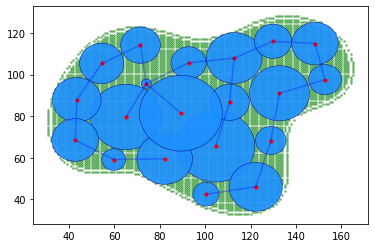

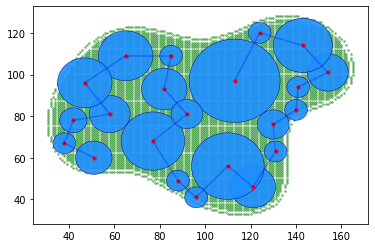

In [94]:
def load_image():
    filepath = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if filepath:
        img = Image.open(filepath)
        img.thumbnail((400, 400))
        img_tk = ImageTk.PhotoImage(img)
        image_label.config(image=img_tk)
        image_label.image = img_tk
        global image_path
        image_path = filepath

def display_image(fig, img_title):
    window = Toplevel(app)
    window.title(img_title)
    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()
    canvas.get_tk_widget().pack()


def process_sprinklers_entry():
    try:
        # Pobierz tekst z pola Entry dla liczby zraszaczy
        num_sprinklers_text = num_sprinklers_entry.get()
        num_sprinklers = int(num_sprinklers_text)
        
        text = list_sprinklers_entry.get()
        sprinkler_radii = [float(num) for num in text.split(',')]
        
    except ValueError as e:
            
        # Obsłuż błąd w przypadku niepoprawnych danych wejściowych
        messagebox.showerror("Błąd", f"Proszę wprowadzić poprawne dane: {str(e)}")
    
    return sprinkler_radii


def process_image():
    if not image_path or not num_sprinklers_entry.get():
        messagebox.showwarning("Uwaga", "Proszę wczytać obraz oraz podać liczbę zraszaczy")
        return

    ### klastrowanie - kod Szymon
    num_sprinklers = int(num_sprinklers_entry.get())

    imag = Image.open(image_path)
    new_pic_width = 200  # teoretycznie te wartości można zmienić
    new_pic_height = 160
    
    
    data_clust, data_plot, circuit = extract_data(imag, new_pic_width, new_pic_height) # zwracane są zmienne wcześniej używane jako data, data_dense, obwod_dane_dense

    ### dane do późniejszego wykorzystania (funkcja ceny, opłacalność) 
    rads, cents, garden_hose, irrigation, fig1 = clustering_with_graph(num_sprinklers, data_clust, data_plot, circuit, plot=True, graph_plot=True)
  
    
    display_image(fig1, "Kod Deterministyczny")
    ### klastrowanie - kod Szymon
    
    ### kod Agaty
    resized_img = imag.resize((new_pic_width, new_pic_height), Image.LANCZOS)
    # wcześniejsze odwrócenie zdjęcia, po to, aby było zgodne z wczytywanym obrazkiem
    flipped_img = resized_img.transpose(Image.FLIP_TOP_BOTTOM)

    # Zapisujemy zmniejszony obraz (potrzebne do kodu agaty)
    flipped_img.save('garden_lower_resolution_v2.jpg')
    c1 = ['#b6950c', '#9d150b']

    list_sprinklers = process_sprinklers_entry()

    shape = ShapeFill('garden_lower_resolution_v2.jpg', n=500, rho_min = 0.01, rho_max=0.5, colours="b", r_list = list_sprinklers)
    shape.guard = 1000
    shape.make_circles(c_idx=range(len(c1)))
    
    ### dane do późniejszego wykorzystania (funkcja ceny, opłacalność)
    centers, radiuses = shape.change()
    garden_hose2, irrigation2, fig2 = garden_plotter(centers, radiuses, data_plot, plot=True, graph_plot=True)

    print(garden_hose, irrigation)
    print(garden_hose2, irrigation2)

    display_image(fig2, "Kod Losowy")
    ### kod Agaty

app = tk.Tk()
app.title("Rozmieszczenie zraszaczy GUI")
app.geometry("800x800")
app.configure(bg="#4CAF50")

image_path = None

frame = tk.Frame(app, bg="forestgreen")
frame.pack(pady=20)

load_image_button = tk.Button(frame, text="Wczytanie obrazu", command=load_image, bg="#4CAF50", fg="white", font=("Arial", 12))
load_image_button.grid(row=0, column=0, padx=10, pady=10)

image_label = tk.Label(frame, bg="forestgreen")
image_label.grid(row=1, column=0, padx=10, pady=10)

tk.Label(frame, text="Liczba zraszaczy:", bg="#4CAF50", fg="white", font=("Arial", 13)).grid(row=2, column=0, padx=10, pady=10)
num_sprinklers_entry = tk.Entry(frame, font=("Arial", 12))
num_sprinklers_entry.grid(row=3, column=0, padx=10, pady=10)

tk.Label(frame, text="Lista możliwych promieni zraszaczy:", bg="#4CAF50", fg="white", font=("Arial", 13)).grid(row=4, column=0, padx=10, pady=10)
list_sprinklers_entry = tk.Entry(frame, font=("Arial", 12))
list_sprinklers_entry.grid(row=5, column=0, padx=10, pady=10)

process_image_button = tk.Button(frame, text="Przetworzenie obrazu", command=process_image, bg="#4CAF50", fg="white", font=("Arial", 12))
process_image_button.grid(row=6, column=0, padx=10, pady=10)

app.mainloop()


# najlepiej podawać listę zraszaczy: 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
# lub: 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0